## 章節 5：發生比與分佈相加（Odds and Addends）

### 5.4 加數（Addends）

**分佈更新**是貝葉斯統計中的基礎操作，給定先驗分佈和一組資料產生後驗分佈。

但是解決真實問題往往需要數種操作，像是縮放（scaling）、加法或是其他的算術運算操作、最大值、最小值和混合體（mixture）。接下來介紹加法和最大值；其他的操作直到用到我會說明。

第一個例子是來自一種角色扮演的遊戲 Dungeons & Dragons，玩家通常是用擲骰子做決策。事實上，在遊戲開始前，玩家擲六面骰子三次，並且加總來決定角色的屬性包含強度、智力、智慧、體質、敏捷、體質與魅力。所以你應該會好奇這個相加的分佈長怎樣。有兩種方式計算它：

1. 模擬法(Simulation)：給定一個代表單一骰子的 Pmf 分佈，做多次隨機取樣將其加總，產生模擬加總的分佈。
1. 列舉法(Enumeration)：給定兩個 Pmf 分佈，你可以列舉所有兩兩配對的加總結果來產生加總的分佈。

### 模擬法（Simulation）

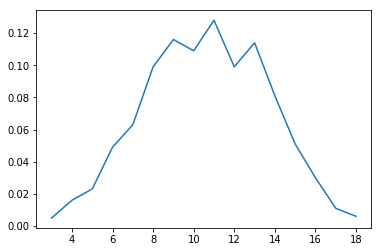

In [37]:
from thinkbayes import Pmf, SampleSum
import matplotlib.pyplot as plt

def plot_suite(suite):
    x, y = zip(*sorted(suite.Items()))
    plt.plot(x, y)


class Die(Pmf): # 定義一個骰子的類別
    def __init__(self, sides):
        super().__init__()
        for num in range(1, sides+1):
            self.Set(num, 1) # 均勻分佈
            
        self.Normalize()
        

d6 = Die(6) # 產生一個六面骰子
dices = [d6] * 3 # 投擲六面骰子三次
sample_size = 1000 # 模擬的次數

# SampleSum 方法將一序列的 Pmf 或是 Cdf 物件做 sample_size 次數的隨機取樣後加總，產生另一個 Pmf 物件。
three = SampleSum(dices, sample_size) 
plot_suite(three)

下面提供 thinkbayes.SampleSum 方法的實作

<pre>
def SampleSum(dists, n):
    pmf = MakePmfFromList(RandomSum(dists) for i in xrange(n))
    return pmf
    
def RandomSum(dists):
    total = sum(dist.Random() for dist in dists) # 將亂數取樣的結果加總
    return total

def Random(self):
    """Chooses a random element from this PMF.

    Returns:
        float value from the Pmf
    """
    if len(self.d) == 0:
        raise ValueError('Pmf contains no values.')

    # CDF 反函數取樣法（Inverse CDF）
    target = random.random()
    total = 0.0
    for x, p in self.d.items(): 
        total += p
        if total >= target:
            return x

    # we shouldn't get here
    assert False
</pre>

模擬法(Simulation)的缺點是這產生的分佈是近似正確（您可以執行多次，若sample_size較小，則分佈的變異較大）。隨著取樣次數變大則準確度更高，但也會增加執行時間。

### 列舉法（Enumeration）

列舉法要列舉所有數值相加的配對，並且計算其對應的機率。Pmf 類別中實作 Pmf.\_\_add\_\_ （加法重載）方法。下方提供 thinkbayes.Pmf 嚇得 def \_\_add\_\_ 實作。

<pre>

# class Pmf
def __add__(self, other):
    # self 就是一個 Pmf 物件
    # other 可以是 Pmf 物件或是有提供 Items 方法的物件
    pmf = Pmf()
    for v1, p1 in self.Items():
        for v2, p2 in other.Items():
            pmf.Incr(v1+v2, p1*p2) # 數值相加，機率假設
            
    return pmf # 回傳相加的 Pmf 物件
</pre>

\_\_add\_\_ 的執行時間等於 len(self)*len(other)。

接下來用列舉法產生分佈：

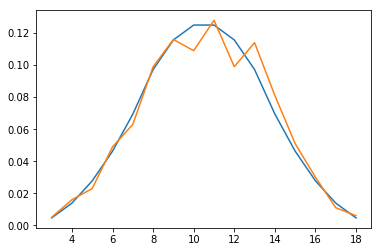

In [38]:
# 當用加號時， __add__ 便被呼叫。在此呼叫兩次。
three_exact = d6 + d6 + d6
plot_suite(three_exact) # 藍色線條
plot_suite(three) # 橘色線條

上圖將模擬法以及列舉法的結果作圖。

Pmf.\_\_add\_\_ 方法是假設兩個 Pmf 之間是**獨立**的，所以機率相乘。在這個擲多次骰子的情況還算適用。但在其他的情況我們可能要用條件機率計算。

您可以在此下載作者個程式碼：http://thinkbayes.com/dungeons.py